In [124]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest
from itertools import combinations

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [125]:
df1 = pd.read_csv("Files/Customer Flight Activity.csv")

In [126]:
columnas_traducidas = {
    'Loyalty Number': 'numero_cliente',
    'Year': 'ano',
    'Month': 'mes',
    'Flights Booked': 'vuelos_reservados',
    'Flights with Companions': 'vuelos_con_acompanantes',
    'Total Flights': 'total_vuelos',
    'Distance': 'distancia',
    'Points Accumulated': 'puntos_acumulados',
    'Points Redeemed': 'puntos_canjeados',
    'Dollar Cost Points Redeemed': 'costo_en_dolares_de_los_puntos_canjeados'
}
df1.rename(columns= columnas_traducidas, inplace=True)

Vamos a eliminar las filas duplicadas

In [127]:
# Comprobamos el numero de duplicados
print(f"El número de duplicados es {df1.duplicated(keep=False).sum()}")
# comprobamos el numero de filas
print(f"El número de filas antes de borrar los duplicados es {df1.shape[0]}")
# Eliminamos los duplicados
df1.drop_duplicates(keep = False, inplace=True)
# Comprobamos
print(f"El número de filas después de borrar los duplicados es {df1.shape[0]}")
print(f"El cálculo es correcto {405624-3712}")

El número de duplicados es 3712
El número de filas antes de borrar los duplicados es 405624
El número de filas después de borrar los duplicados es 401912
El cálculo es correcto 401912


In [128]:
df1.duplicated().sum()

0

In [129]:
df1.describe()

,numero_cliente,ano,mes,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
count,401912.000000,401912.000000,401912.000000,401912.000000,401912.000000,401912.000000,401912.000000,401912.000000,401912.000000,401912.000000
mean,549716.502379,2017.500697,6.502662,4.153058,1.041335,5.194393,1220.045097,124.835129,30.980384,2.507449
std,258983.993365,0.500000,3.451923,5.234539,2.084059,6.532401,1435.019919,146.790294,126.029363,10.193981
min,100018.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326267.000000,2017.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550519.000000,2018.000000,7.000000,1.000000,0.000000,2.000000,555.000000,57.000000,0.000000,0.000000
75%,772025.000000,2018.000000,10.000000,8.000000,1.000000,10.000000,2352.000000,240.000000,0.000000,0.000000
max,999986.000000,2018.000000,12.000000,21.000000,11.000000,32.000000,6293.000000,676.500000,876.000000,71.000000


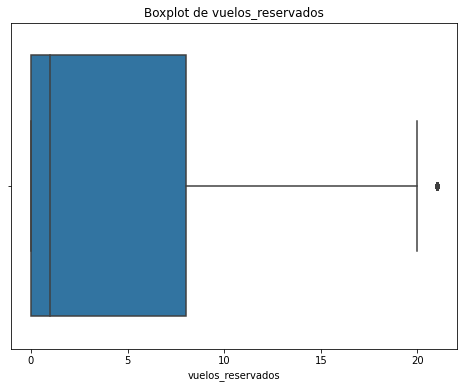

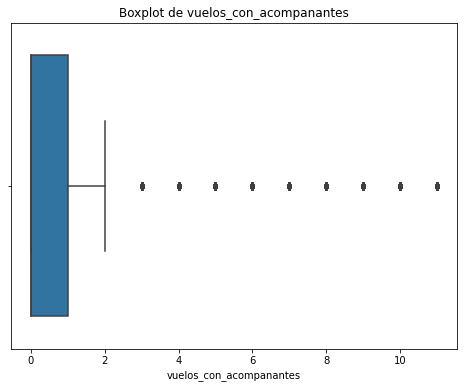

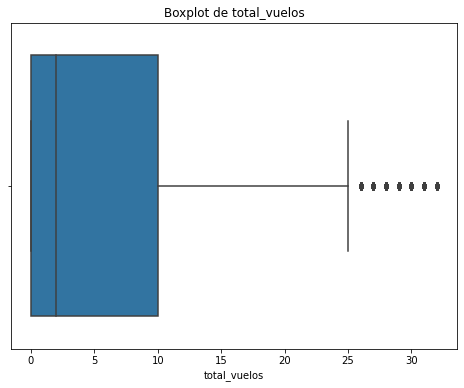

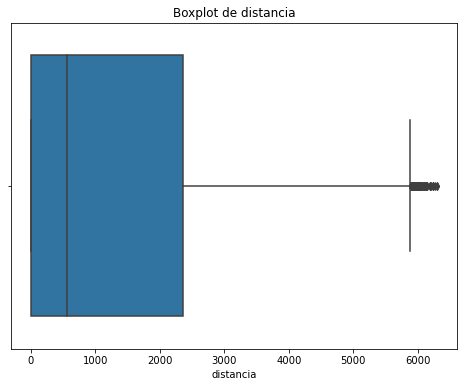

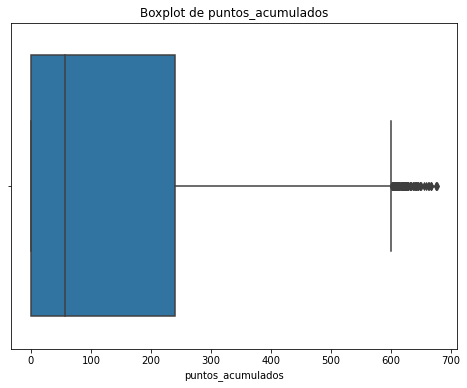

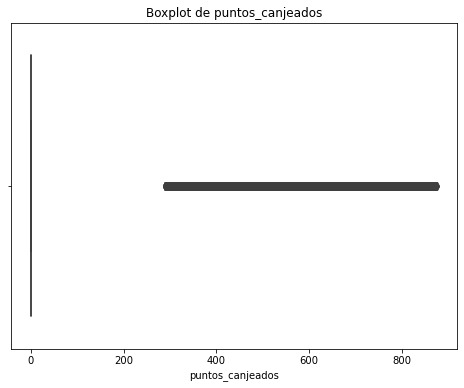

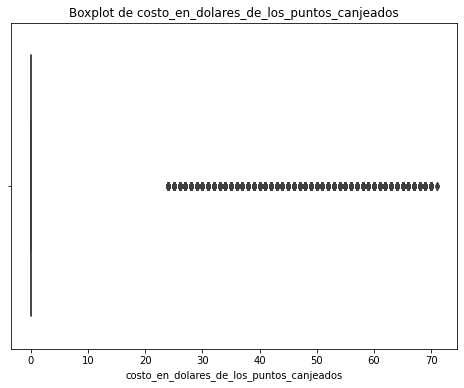

In [130]:
for columna in df1.iloc[:,3:]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df1[columna])
    plt.title(f'Boxplot de {columna}')
    plt.xlabel(columna)
    plt.show()

In [131]:
df1[df1["costo_en_dolares_de_los_puntos_canjeados"]!=0].shape[0]/df1.shape[0]*100

6.016491172196899

In [132]:
df1[df1["costo_en_dolares_de_los_puntos_canjeados"]==0].shape[0]/df1.shape[0]*100

93.98350882780309

Cerca del 6% realiza coste canjando puntos  --> Analicemos esta media

El 94% no causa coste canjeando puntos

In [133]:
df_con_gasto = df1[df1["costo_en_dolares_de_los_puntos_canjeados"]!=0]

In [134]:
df_con_gasto["costo_en_dolares_de_los_puntos_canjeados"].describe()

count    24181.000000
mean        41.676275
std          9.736304
min         24.000000
25%         34.000000
50%         41.000000
75%         48.000000
max         71.000000
Name: costo_en_dolares_de_los_puntos_canjeados, dtype: float64

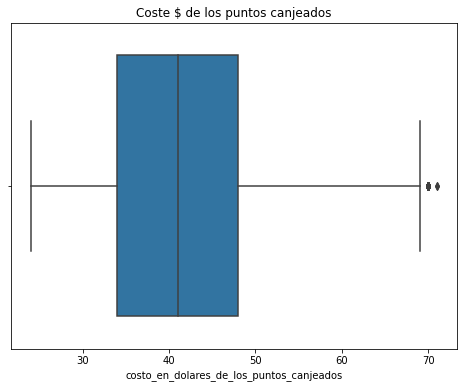

In [135]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = df_con_gasto["costo_en_dolares_de_los_puntos_canjeados"]);
plt.title(f"Coste $ de los puntos canjeados")
# plt.xlabel(columna)
plt.show()

Esto ya nos deja ver cual es el coste de la gente que canjea puntos. Vamos a comprobar pero debe de estar relacionado con los puntos canjeados

In [136]:
df1[df1["puntos_canjeados"]!=0].shape[0]/df1.shape[0]*100

6.016491172196899

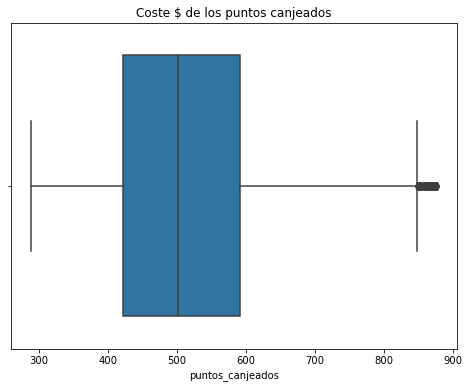

In [137]:
plt.figure(figsize=(8, 6))
sns.boxplot(x= df_con_gasto["puntos_canjeados"]);
plt.title(f"Coste $ de los puntos canjeados")
# plt.xlabel(columna)
plt.show()

Efectivamente parece que esta relacionado 

In [138]:
numericas = df1.select_dtypes(include = np.number).columns
combinaciones = list(combinations(numericas, 2))

In [139]:
# creamos una función para identificar si las relaciones entre las variables son lienales o no
def identificar_linealidad (dataframe, lista_combinacion_columnas):
    """
    Identifica si las relaciones entre pares de variables en un DataFrame son lineales o no.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        El DataFrame que contiene las variables a analizar.

    lista_combinacion_columnas : list of tuples
        Una lista de tuplas donde cada tupla contiene dos nombres de columnas del DataFrame que se desea analizar.

    Returns:
    --------
    relaciones_lineales : list of tuples
        Una lista de tuplas que contienen los nombres de las columnas que tienen una relación lineal.

    relaciones_no_lineales : list of tuples
        Una lista de tuplas que contienen los nombres de las columnas que no tienen una relación lineal.

    """
    relaciones_lineales = []
    relaciones_no_lineales = []

    for tupla in lista_combinacion_columnas: 
        # Realizar la prueba de normalidad
        _, p_value1 = kstest(dataframe[tupla[0]], "norm")
        _, p_value2 = kstest(dataframe[tupla[1]], "norm")

        if p_value1 > 0.05 and p_value2 > 0.05:
            relaciones_lineales.append(tupla)
        else:
            relaciones_no_lineales.append(tupla)

    return relaciones_lineales, relaciones_no_lineales

# llamamos a la funcion

lineal, no_lineal = identificar_linealidad(df1, combinaciones)

print(f"Las variables a las que tengamos que aplicar la correlacion de pearson son: {lineal}")
print(f"Las variables a las que tengamos que aplicar la correlacion de spearman son: {no_lineal}")

Las variables a las que tengamos que aplicar la correlacion de pearson son: []
Las variables a las que tengamos que aplicar la correlacion de spearman son: [('numero_cliente', 'ano'), ('numero_cliente', 'mes'), ('numero_cliente', 'vuelos_reservados'), ('numero_cliente', 'vuelos_con_acompanantes'), ('numero_cliente', 'total_vuelos'), ('numero_cliente', 'distancia'), ('numero_cliente', 'puntos_acumulados'), ('numero_cliente', 'puntos_canjeados'), ('numero_cliente', 'costo_en_dolares_de_los_puntos_canjeados'), ('ano', 'mes'), ('ano', 'vuelos_reservados'), ('ano', 'vuelos_con_acompanantes'), ('ano', 'total_vuelos'), ('ano', 'distancia'), ('ano', 'puntos_acumulados'), ('ano', 'puntos_canjeados'), ('ano', 'costo_en_dolares_de_los_puntos_canjeados'), ('mes', 'vuelos_reservados'), ('mes', 'vuelos_con_acompanantes'), ('mes', 'total_vuelos'), ('mes', 'distancia'), ('mes', 'puntos_acumulados'), ('mes', 'puntos_canjeados'), ('mes', 'costo_en_dolares_de_los_puntos_canjeados'), ('vuelos_reservados',

In [140]:
df_correlaciones = df1.iloc[:,3:].corr( method = "spearman")
df_correlaciones

,vuelos_reservados,vuelos_con_acompanantes,total_vuelos,distancia,puntos_acumulados,puntos_canjeados,costo_en_dolares_de_los_puntos_canjeados
vuelos_reservados,1.000000,0.560299,0.987388,0.896666,0.894306,0.221742,0.221742
vuelos_con_acompanantes,0.560299,1.000000,0.670493,0.580303,0.578156,0.398404,0.398404
total_vuelos,0.987388,0.670493,1.000000,0.900830,0.898169,0.262851,0.262851
distancia,0.896666,0.580303,0.900830,1.000000,0.998019,0.237550,0.237549
puntos_acumulados,0.894306,0.578156,0.898169,0.998019,1.000000,0.237484,0.237483
puntos_canjeados,0.221742,0.398404,0.262851,0.237550,0.237484,1.000000,0.999999
costo_en_dolares_de_los_puntos_canjeados,0.221742,0.398404,0.262851,0.237549,0.237483,0.999999,1.000000


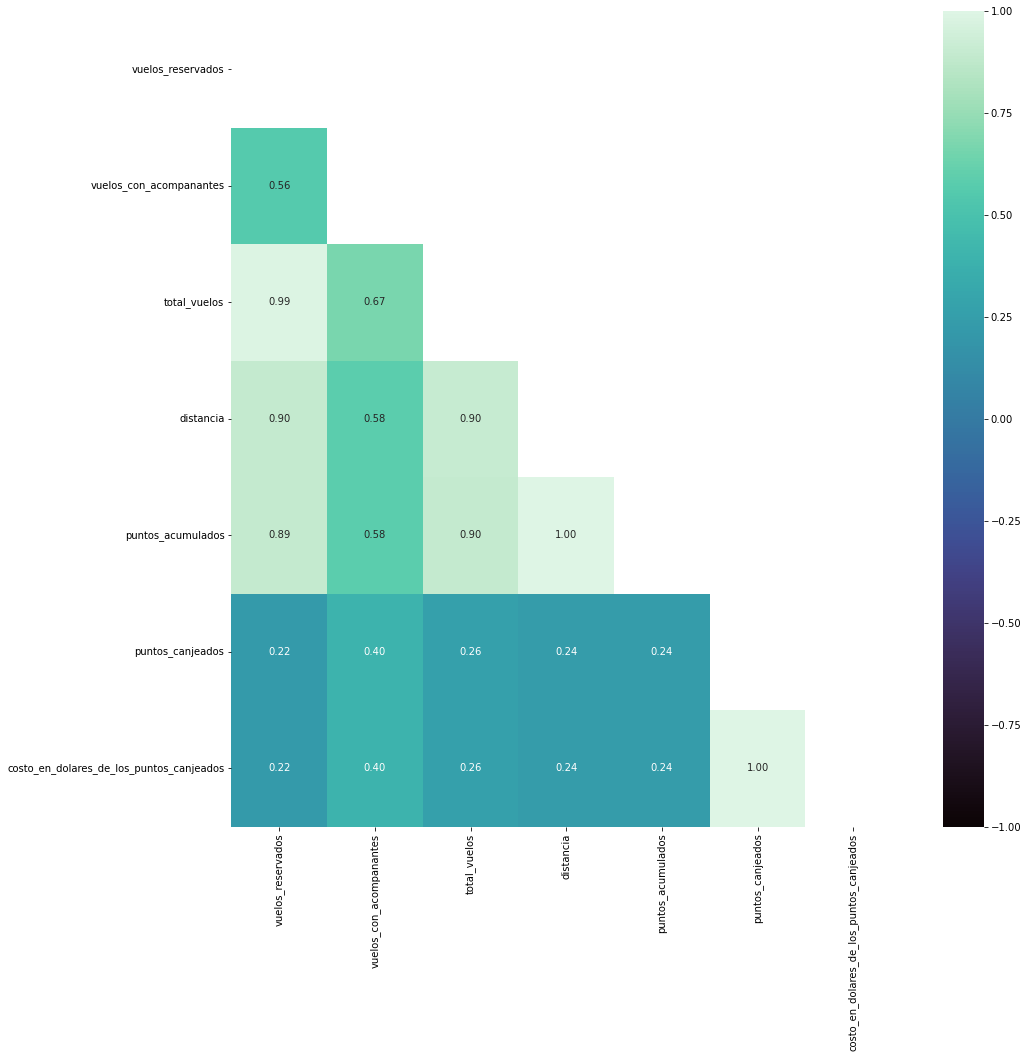

In [141]:
# AHORA YA PODREMOS ENTENDER DE UNA FORMA MÁS AMIGABLE LOS RESULTADOS DE LA MATRIZ DE CORRELACIÓN
# establecemos el tamaño de la gráfica
plt.figure(figsize = (15, 15))

# creamos una matriz booleana de máscara
mask = np.triu(np.ones_like(df_correlaciones, dtype=bool))

# creamos un heatmap con la máscara
sns.heatmap(df_correlaciones, 
            annot = True, 
            fmt = ".2f", 
            cmap = "mako", 
            vmax = 1, 
            vmin = -1, 
            mask = mask); 

In [145]:
df1[['distancia', 'puntos_acumulados']].describe()

,distancia,puntos_acumulados
count,401912.000000,401912.000000
mean,1220.045097,124.835129
std,1435.019919,146.790294
min,0.000000,0.000000
25%,0.000000,0.000000
50%,555.000000,57.000000
75%,2352.000000,240.000000
max,6293.000000,676.500000


<AxesSubplot:xlabel='distancia', ylabel='puntos_acumulados'>

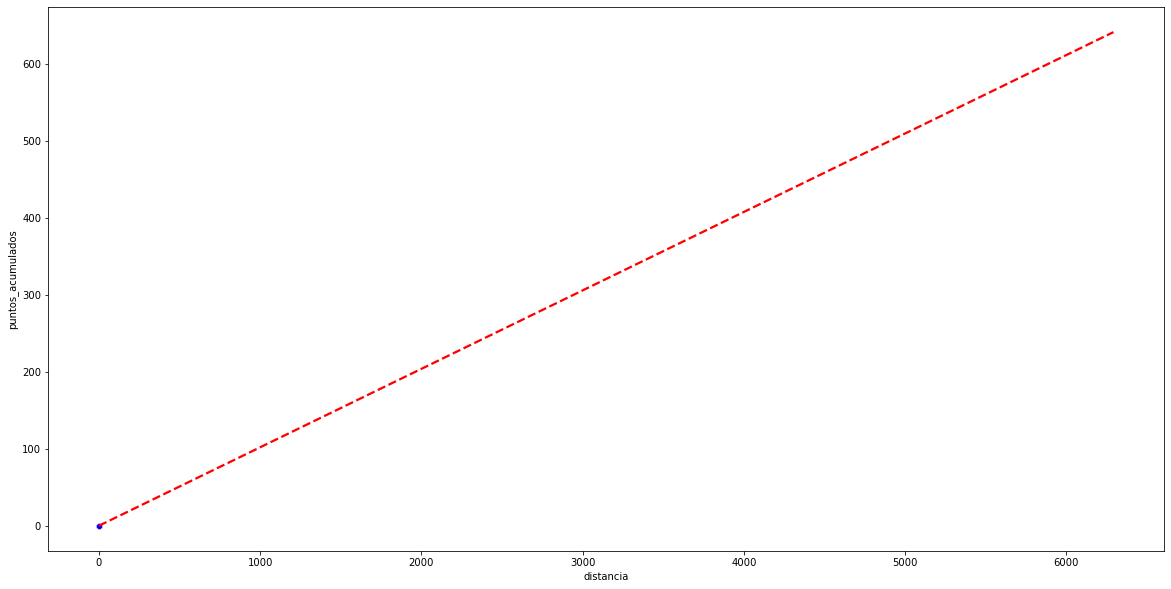

In [150]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x = "distancia", 
                y = "puntos_acumulados", 
                data = df,
                hue = "tarjeta_lealtad",
                color = "blue")
sns.regplot(x='distancia', y='puntos_acumulados', data=df1, scatter=False, color='red', line_kws={'linestyle': '--'})

1. **Correlación Débil**:

   - El valor absoluto del coeficiente de correlación está cerca de 0.

   - Por lo general, se considera una correlación débil si el valor absoluto está por debajo de 0.3.

   - 

2. **Correlación Moderada**:

   - El valor absoluto del coeficiente de correlación está en el rango de 0.3 a 0.7.

   - Se considera una correlación moderada si el valor absoluto está en este rango.

3. **Correlación Fuerte**:

   - El valor absoluto del coeficiente de correlación es igual o superior a 0.7.

   - Se considera una correlación fuerte si el valor absoluto está en este rango.

In [ ]:
df1.to_csv("Files/Customer Flight Activity_limpio.csv", index=False)